<h2 style="color:red;text-align:center;font-weight:bold;">AeroStream Analytics</h2>

AeroStream Analytics est un système intelligent de classification automatique des avis clients des compagnies aériennes. Il analyse en temps réel le sentiment des utilisateurs afin de mesurer leur niveau de satisfaction et fournir des indicateurs clés de performance.

**Objectifs :**

Développer un système de classification automatique des avis clients en temps réel, Le
système devra permettre de:

- Collecter et prétraiter les avis clients,

- Analyser automatiquement le sentiment et la satisfaction,

- Générer des indicateurs de performance par compagnie aérienne,

- Visualiser les résultats via un tableau de bord interactif.

![Python](https://img.shields.io/badge/Python-3.9%2B-blue)
![Airflow](https://img.shields.io/badge/Apache%20Airflow-Orchestration-green)
![Streamlit](https://img.shields.io/badge/Streamlit-Dashboard-red)
![ChromaDB](https://img.shields.io/badge/ChromaDB-Vector%20Store-orange)

<br>

<h3 style="color:green;font-weight:bold;">Entraînement et Evaluation des Modèles SetFit :</h3>

<h4 style="color:orange;font-weight:bold;">1. Charger les Données :</h4>

In [13]:
import chromadb

client = chromadb.PersistentClient(path="../chroma_db")

def getting_collection(client, name) :
    collection = client.get_collection(name=name)
    data = collection.get(include=['embeddings','metadatas'])
    return collection, data

train_collection, train_data = getting_collection(client, "train")

test_collection, test_data = getting_collection(client, "test")

<h4 style="color:orange;font-weight:bold;">2. Séparer les Données d'Entraînement et de Test :</h4>

In [14]:
import numpy as np

def split_data(data, name) :
    X = np.array([d['text'] for d in data['metadatas']])
    y = np.array([d['sentiment'] for d in data['metadatas']])
    
    print(f"- Dimensions X_{name} : {X.shape}")
    print(f"- Dimensions y_{name} : {y.shape}")
    
    return X, y

X_train, y_train = split_data(train_data, "train")

- Dimensions X_train : (11376,)
- Dimensions y_train : (11376,)


In [15]:
X_test, y_test = split_data(test_data, "test")

- Dimensions X_test : (2844,)
- Dimensions y_test : (2844,)


<h4 style="color:orange;font-weight:bold;">3. Encodage des Sentiments :</h4>

In [16]:
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

train_ds = Dataset.from_dict({
    "text": X_train,
    "label": y_train
})

test_ds = Dataset.from_dict({
    "text": X_test,
    "label": y_test
})

<h4 style="color:orange;font-weight:bold;">4. Entrainement, Evaluation et Sauvegarde de Modèle SetFit :</h4>

<h5 style="font-weight:bold;">4.1. Fonctions Utiles :</h5>

In [21]:
from setfit import SetFitTrainer, SetFitModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sentence_transformers.losses import CosineSimilarityLoss


# Fonction pour l'Entraînement de SetFitModel
def train_setfit(train_ds, test_ds, model_id, num_iterations=2):
    model = SetFitModel.from_pretrained(model_id)
    
    trainer = SetFitTrainer(
        model=model,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        loss_class=CosineSimilarityLoss,
        metric="accuracy",
        batch_size=16,
        num_iterations=num_iterations,
        num_epochs=1,
        column_mapping={"text": "text", "label": "label"}
    )
    
    print(f"- Entraînement du Modèle ...")
    trainer.train()
    print("- Fin d'Entraînement !")
    
    return model




# Fonction pour l'Evaluation de SetFitModel
def evaluate_setfit(model, X_test, y_test, target_names):
    print("\n" + "="*60)
    print("ÉVALUATION DU MODÈLE SETFIT")
    print("="*60)
    
    y_pred_train = model.predict(list(X_train))
    y_pred_test = model.predict(list(X_test))
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    print(f"- Accuracy Train : {acc_train:.4f}")
    print(f"- Accuracy Test : {acc_test:.4f}")
    
    print(f"- Gap Overfiting : {(acc_train - acc_test):.4f}")
    
    print("\n- Rapport de Classification :")
    print(classification_report(y_test, y_pred_test, target_names=target_names))
    
    print("- Génération de la Matrice de Confusion...")
    cm = confusion_matrix(y_test, y_pred_test)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Matrice de Confusion - SetFit')
    plt.ylabel('Vrai Label')
    plt.xlabel('Label Prédit')
    plt.show()




# Fonction pour l'Evaluation de SetFitModel
def save_setfit(model, name):
    path = "../models/SetFit"
    
    if not os.path.exists(path):
        os.makedirs(path)
        
    model.save_pretrained(os.path.join(path, name))
    
    print(f"Modèle Sauvegardé avec Succès dans : {path + name}")


target_names = ["negative", "neutral", "positive"]

<h5 style="font-weight:bold;">4.2. Entraînement :</h5>

In [18]:
model_id = "sentence-transformers/all-MiniLM-L6-v2"
setfit_model = train_setfit(train_ds, test_ds, model_id)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
C:\Users\abdel\AppData\Local\Temp\ipykernel_21304\1687910474.py:13: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
Map: 100%|██████████| 11376/11376 [00:00<00:00, 21164.60 examples/s]


- Entraînement du Modèle ...


***** Running training *****
  Num unique pairs = 45504
  Batch size = 16
  Num epochs = 1
c:\Users\abdel\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.477200
50,0.322300
100,0.252500
150,0.209300
200,0.195000
250,0.178100
300,0.167200
350,0.158300
400,0.157600
450,0.151000


- Fin d'Entraînement !


<h5 style="font-weight:bold;">4.3. Evaluation :</h5>


ÉVALUATION DU MODÈLE SETFIT
- Accuracy Train : 0.9173
- Accuracy Test : 0.8358
- Gap Overfiting : 0.0815

- Rapport de Classification :
              precision    recall  f1-score   support

    negative       0.90      0.90      0.90      1805
     neutral       0.68      0.67      0.67       593
    positive       0.79      0.78      0.79       446

    accuracy                           0.84      2844
   macro avg       0.79      0.78      0.79      2844
weighted avg       0.83      0.84      0.84      2844

- Génération de la Matrice de Confusion...


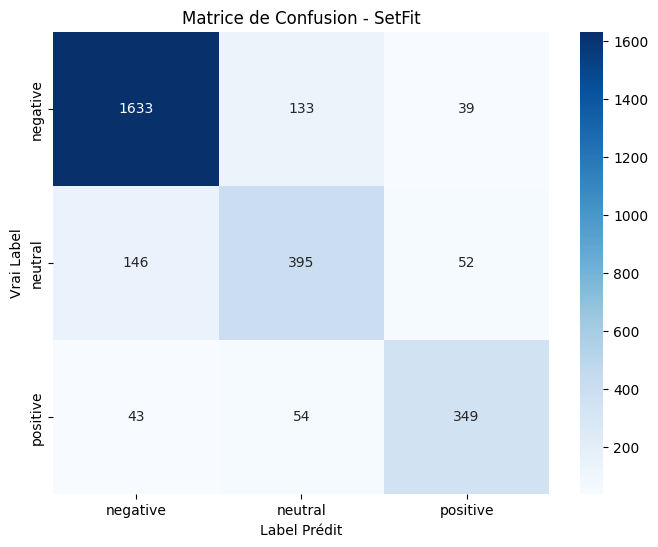

In [22]:
evaluate_setfit(setfit_model, X_test, y_test, target_names)

<h5 style="font-weight:bold;">4.4. Sauvegarde :</h5>

In [23]:
save_setfit(setfit_model, "setfit_model")

Modèle Sauvegardé avec Succès dans : ../models/SetFitsetfit_model
